***
## notebook config

In [1]:
ON_COLAB = False
ASSESS = True

In [2]:
if ON_COLAB:
    from google.colab import drive
    from google.colab import files
    drive.mount('/content/drive', force_remount=True)
    
    !pip install --upgrade kaggle > /dev/null 2>&1
    !mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
    
    !free -h
    
    !pip install --upgrade category_encoders > /dev/null 2>&1
    !pip install --upgrade xgboost > /dev/null 2>&1
    !pip install --upgrade xgbse > /dev/null 2>&1
    !pip install --upgrade optuna > /dev/null 2>&1

In [3]:
if ON_COLAB:
    !kaggle datasets download -d mavillan/meli-2021 --force --unzip
    !ls -halt
    input_path = "./"
    print("input_path:", input_path)
    subs_path = "/content/drive/MyDrive/meli2021/subs"
    print("subs_path:", subs_path)
    results_path = "/content/drive/MyDrive/meli2021/results"
    print("results_path:", results_path)
else:
    input_path = "../data"
    print("input_path:", input_path)
    subs_path = "../subs"
    print("subs_path:", subs_path)
    results_path = "../results"
    print("results_path:", results_path)

input_path: ../data
subs_path: ../subs
results_path: ../results


In [4]:
SEED = 19
SUB_NBR = "09"

***

In [7]:
from copy import deepcopy
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
from scipy import stats
import time

import category_encoders as ce
import xgboost as xgb
from tqdm import tqdm
import optuna

from xgbse import XGBSEDebiasedBCE
from xgbse import XGBSEKaplanNeighbors
from xgbse import XGBSEStackedWeibull
from xgbse import XGBSEBootstrapEstimator 

from xgbse.converters import convert_to_structured

np.random.seed(SEED)
pd.set_option('display.max_columns', None)

In [8]:
def reduce_mem_usage(df, verbose=False):
    """
    Utility function to reduce the memory usage of pandas dataframes
    
    Parameters
    ----------
    df: pandas.Dataframe
    verbose: Boolean
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [9]:
class RMSSE():
    def __init__(self, valid_dataframe, scales_dataframe):
        self.valid_dataframe = valid_dataframe
        self.scales_dataframe = scales_dataframe
        self.apply_inverse = False
        if set(["y_mean","y_std"]) <= set(valid_dataframe.columns):
            self.apply_inverse = True

    def _evaluate(self, predictions):
        valid_dataframe = self.valid_dataframe.copy()
        if not self.apply_inverse:  
            valid_dataframe["ypred"] = predictions
            valid_dataframe["sq_error"] = valid_dataframe.eval("(y-ypred)**2")
        else:
            valid_dataframe["ypred"] = valid_dataframe["y_std"]*predictions + valid_dataframe["y_mean"]
            valid_dataframe["sq_error"] = valid_dataframe.eval("(y_raw-ypred)**2")
        mse = valid_dataframe.groupby("sku")["sq_error"].mean().reset_index(name="mse")
        mrg = pd.merge(mse, self.scales_dataframe, how="inner", on="sku")
        return mrg.eval("sqrt(mse)/scale").mean()

    def evaluate(self, ypred, dtrain):
        metric = self._evaluate(ypred)
        return "rmsse", metric, False

In [10]:
def ranked_probability_score(y_true, y_pred):
    """
    Input
        y_true: np.array of shape 30. 
        y_pred: np.array of shape 30. 
    """
    return ((y_true.cumsum(axis=1) - y_pred.cumsum(axis=1))**2).sum(axis=1).mean()

def scoring_function(y_true, y_pred):
    """
    Input
        y_true: List of Ints of shape Nx1. Contain the target_stock
        y_pred: List of float of shape Nx30. Contain the prob for each day
    """
    y_true_one_hot = np.zeros_like(y_pred, dtype=np.float64)
    y_true_one_hot[range(len(y_true)), y_true-1] = 1
    return ranked_probability_score(y_true_one_hot, y_pred)

In [11]:
def binarize_predictions(dataframe):
    dataframe = dataframe.copy()
    dataframe["pred_bin"] = -1
    bin_limits = np.arange(1.5, 30, 1.)
    
    cut_left = -np.inf
    for cut_right in bin_limits:
        idx = dataframe.query("@cut_left <= pred < @cut_right").index
        dataframe.loc[idx, "pred_bin"] = int(cut_right)
        cut_left = cut_right
        
    idx = dataframe.query("pred >= @cut_right").index
    dataframe.loc[idx, "pred_bin"] = 30
    
    return dataframe

***
## loading data for assessment

In [12]:
if ASSESS:
    dataset = (
        pd.read_parquet(f"{input_path}/train-m2.parquet")
        .rename({"date":"ds", "sold_quantity":"y"}, axis=1,)
        .sort_values(["sku","ds"])
        .reset_index(drop=True)
    )
    
dataset["nrows"] = dataset.groupby("sku")["ds"].transform("count")
print(dataset.sku.nunique())
print(dataset.query("nrows == 30").sku.nunique())

531832
500404


In [13]:
# just for assessment
dataset = (
    dataset
    .query("nrows == 30")
    .query("ds in ('2021-02-01', '2021-03-02')")
    .reset_index(drop=True)
)
print(dataset.sku.nunique())

# skus to remove on validation
skus_to_remove = dataset.query("inventory_days > 30").sku.unique()
dataset = dataset.query("sku not in @skus_to_remove").reset_index(drop=True)
print(dataset.sku.nunique())

500404
272130


In [14]:
dataset["id_lower"] = dataset["inventory_days"].copy() 
dataset["id_upper"] = dataset["inventory_days"].copy()
dataset["event"] = 1

idx = dataset.query("inventory_days > 30").index
dataset.loc[idx,"id_lower"] = 30
dataset.loc[idx,"id_upper"] = np.inf
dataset.loc[idx,"event"] = 0

In [15]:
train_dset = dataset.query("ds == '2021-02-01'").reset_index(drop=True)
valid_dset = dataset.query("ds == '2021-03-02'").reset_index(drop=True)

print(train_dset.sku.nunique())
print(valid_dset.sku.nunique())

272130
272130


In [16]:
numeric_cols = [
    "current_price",
    "listing_type_classic",
    "listing_type_premium",
    "shipping_logistic_type_fulfillment",
    "shipping_logistic_type_cross_docking",
    "shipping_logistic_type_drop_off",
    "shipping_payment_free_shipping",
    "shipping_payment_paid_shipping",
    "minutes_active",
    "weekday_1",
    "weekday_2",
    "weekday_3",
    "weekday_4",
    "weekday_5",
    "weekday_6",
    "weekday_7",
    "q_mean",
    "q_std",
    "target_stock",   
]
print("number of numeric:", len(numeric_cols))

categs_cols = [
    #"sku",
    "item_domain_id",
    #"item_id",
    #"site_id",
    "product_id",
    #"product_family_id",  
]
print("number of categs", len(categs_cols))

categs_to_encode = [
    #"sku",
    #"item_id",
    #"product_family_id",
]

target = "inventory_days"

input_cols = numeric_cols + categs_cols
print("total feats:", len(input_cols))

number of numeric: 19
number of categs 2
total feats: 21


In [17]:
train_dset.loc[:,categs_cols].nunique()

item_domain_id    7553
product_id        6445
dtype: int64

In [18]:
encoder = ce.CatBoostEncoder()
train_dset[categs_cols] = encoder.fit_transform(train_dset[categs_cols], train_dset.eval("target_stock / inventory_days"))
valid_dset[categs_cols] = encoder.transform(valid_dset[categs_cols])

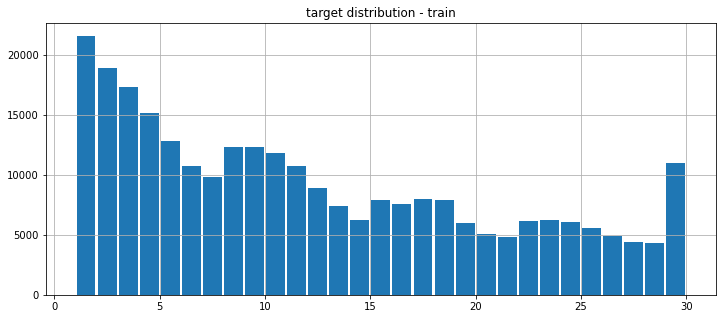

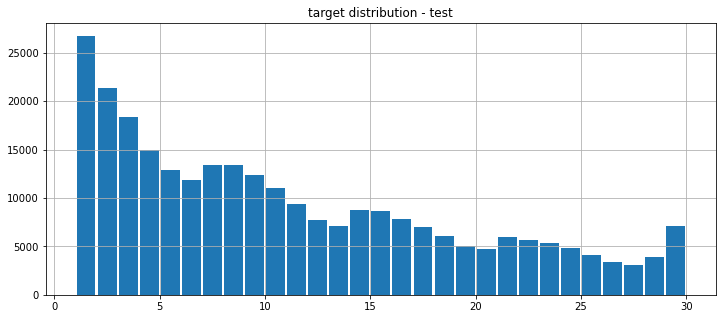

In [19]:
plt.figure(figsize=(12,5))
plt.hist(train_dset[target].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("target distribution - train")
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
plt.hist(valid_dset[target].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("target distribution - test")
plt.grid()
plt.show()

In [20]:
print("Uncensored rows (train):", len(train_dset.query("inventory_days > 30")) / 1e3)
print("Uncensored rows (valid):", len(valid_dset.query("inventory_days > 30")) / 1e3)

Uncensored rows (train): 0.0
Uncensored rows (valid): 0.0


In [21]:
train_dset.query("sku not in @skus_to_remove").sku.nunique()

272130

***
## model training: assessment

In [42]:
model_params = {
    'objective': 'survival:aft',
    'eval_metric': 'aft-nloglik',
    'aft_loss_distribution': 'normal',
    #'aft_loss_distribution': 'logistic',
    #'aft_loss_distribution': 'extreme',
    'aft_loss_distribution_scale': 2.,
    
    #"booster": "dart",
    #'tree_method': 'exact',
    #'tree_method': 'approx',
    'tree_method': 'hist',
    'max_bin': 256,
    
    'grow_policy': 'lossguide',
    'max_leaves': 2**6-1,
    'min_child_weight': 50,
    'max_depth': 10,
    
    'learning_rate': 0.05,
    'max_delta_step':1.,
    
    'colsample_bytree':0.8,
    'subsample':0.95,
    
    'lambda':0.1,
    'seed':SEED,
}

In [51]:
TIME_BINS = np.arange(0.5, 50.5, 1)
TIME_BINS

array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
       11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
       22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
       33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5,
       44.5, 45.5, 46.5, 47.5, 48.5, 49.5])

In [52]:
models_by_site = list()
sites = ["MLA","MLB","MLM"]
oof_preds = list()

for site in sites:
    print("-"*90)
    print(f"Training model for site: {site} \n")
    
    _train_dset = train_dset.query("site_id == @site").reset_index(drop=True)
    _valid_dset = valid_dset.query("site_id == @site").reset_index(drop=True)
    sample_index = _train_dset.sample(frac=0.25).index
    
    #model = XGBSEDebiasedBCE(xgb_params=model_params, )
    #model = XGBSEKaplanNeighbors(xgb_params=model_params, )
    model = XGBSEStackedWeibull(xgb_params=model_params, )
    
    X_train = _train_dset.loc[:, numeric_cols+categs_cols]
    y_train = convert_to_structured(_train_dset.inventory_days, _train_dset.event)
    
    X_valid = _valid_dset.loc[:, numeric_cols+categs_cols]
    y_valid = convert_to_structured(_valid_dset.inventory_days, _valid_dset.event)

    model.fit(
        X_train, y_train,
        validation_data = (X_valid, y_valid),
        num_boost_round=5000,
        early_stopping_rounds=50,
        verbose_eval=25,
        time_bins=TIME_BINS
    )
    
    break
    

    xgb.plot_importance(model, height=0.5, importance_type="weight", title="weight")
    xgb.plot_importance(model, height=0.5, importance_type="gain", title="gain")
    xgb.plot_importance(model, height=0.5, importance_type="cover", title="cover")
    plt.show()
    
    _valid_dset["pred"] = np.clip(model.predict(dvalid), a_min=None, a_max=30)
    _valid_dset = binarize_predictions(_valid_dset)
    oof_preds.append(_valid_dset)
    models_by_site.append(model)

------------------------------------------------------------------------------------------
Training model for site: MLA 

[0]	validation-aft-nloglik:4.48910
[25]	validation-aft-nloglik:3.88196
[50]	validation-aft-nloglik:3.65228
[75]	validation-aft-nloglik:3.61578
[100]	validation-aft-nloglik:3.61214
[125]	validation-aft-nloglik:3.61236
[150]	validation-aft-nloglik:3.61254


In [53]:
help(model.predict)

Help on method predict in module xgbse._stacked_weibull:

predict(X, return_interval_probs=False) method of xgbse._stacked_weibull.XGBSEStackedWeibull instance
    Predicts survival probabilities using the XGBoost + Weibull AFT stacking pipeline.
    
    Args:
        X (pd.DataFrame): Dataframe of features to be used as input for the
            XGBoost model.
    
        return_interval_probs (Bool): Boolean indicating if interval probabilities are
            supposed to be returned. If False the cumulative survival is returned.
            Default is False.
    
    Returns:
        pd.DataFrame: A dataframe of survival probabilities
        for all times (columns), from a time_bins array, for all samples of X
        (rows). If return_interval_probs is True, the interval probabilities are returned
        instead of the cumulative survival probabilities.



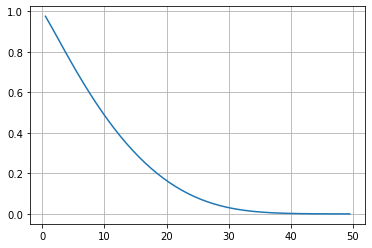

In [61]:
predictions = model.predict(X_valid, return_interval_probs=False)
predictions.mean(axis=0).plot()
plt.grid()
plt.show()

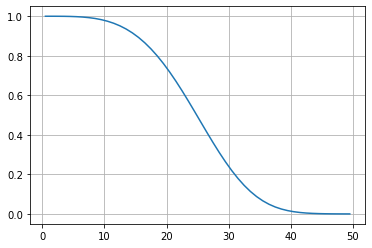

In [55]:
# weibull
predictions.loc[24].plot()
plt.grid()
plt.show()

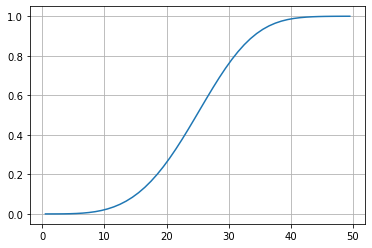

In [69]:
# weibull
(1-predictions).loc[24].plot()
plt.grid()
plt.show()

In [70]:
z = (1-predictions).loc[24].values.copy()
z

array([2.20386933e-07, 1.48122169e-05, 1.04787751e-04, 3.80137212e-04,
       9.95049092e-04, 2.14482167e-03, 4.06305033e-03, 7.01846520e-03,
       1.13109710e-02, 1.72665018e-02, 2.52303428e-02, 3.55586203e-02,
       4.86077368e-02, 6.47216403e-02, 8.42169704e-02, 1.07366327e-01,
       1.34380150e-01, 1.65387976e-01, 2.00420131e-01, 2.39391179e-01,
       2.82086690e-01, 3.28154974e-01, 3.77105419e-01, 4.28314837e-01,
       4.81042757e-01, 5.34455956e-01, 5.87661636e-01, 6.39747684e-01,
       6.89827466e-01, 7.37085770e-01, 7.80821960e-01, 8.20486322e-01,
       8.55705943e-01, 8.86297481e-01, 9.12265499e-01, 9.33786734e-01,
       9.51182314e-01, 9.64881331e-01, 9.75380089e-01, 9.83201547e-01,
       9.88859076e-01, 9.92827592e-01, 9.95523780e-01, 9.97295672e-01,
       9.98420586e-01, 9.99109578e-01, 9.99516136e-01, 9.99746936e-01,
       9.99872809e-01, 9.99938662e-01])

In [72]:
orig = np.insert(np.diff(z), 0, z[0])

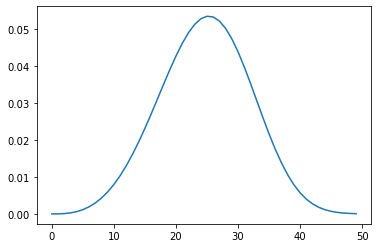

In [74]:
plt.plot(orig.cumsum())

***
## analysis of OOF predictions

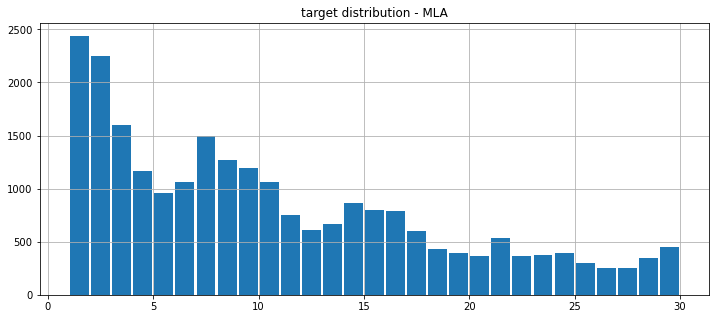

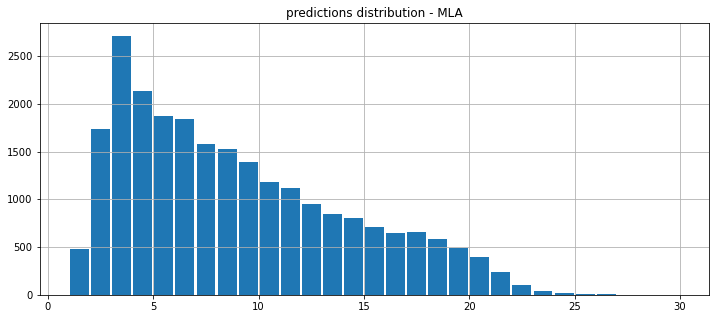

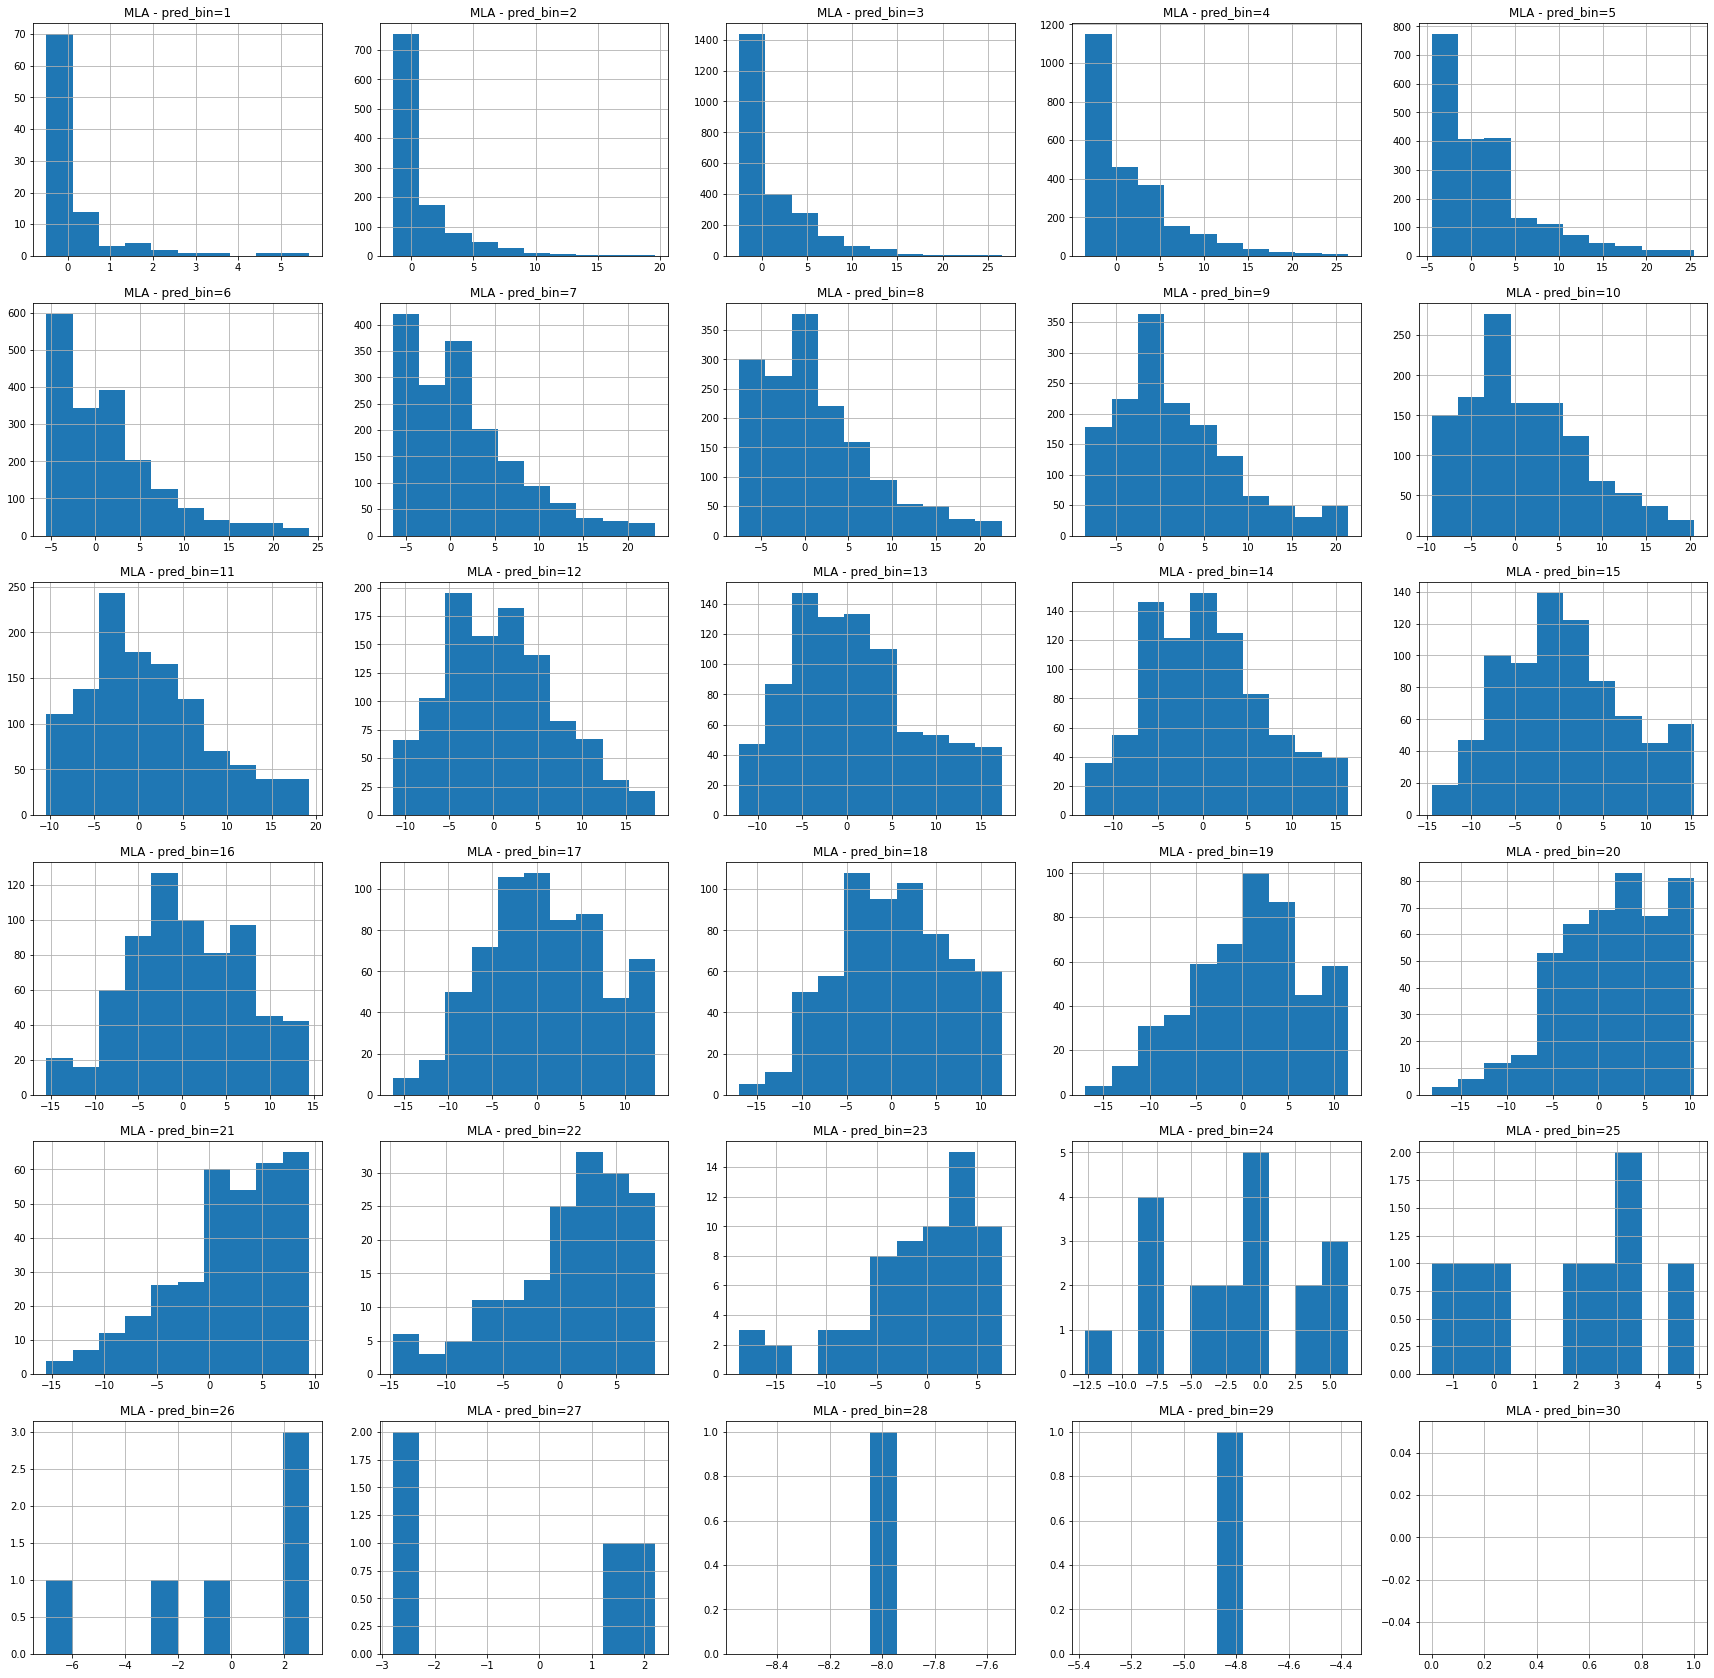

In [23]:
# results for MLA
plt.figure(figsize=(12,5))
plt.hist(oof_preds[0][target].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("target distribution - MLA")
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
plt.hist(oof_preds[0]["pred"].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("predictions distribution - MLA")
plt.grid()
plt.show()

plt.figure(figsize=(30,30))
for d in range(1,31):
    deviation = oof_preds[0].query("pred_bin == @d").eval("inventory_days - pred")
    plt.subplot(6, 5, d)
    plt.hist(deviation.values)
    plt.title(f"MLA - pred_bin={d}")
    plt.grid()
plt.show()

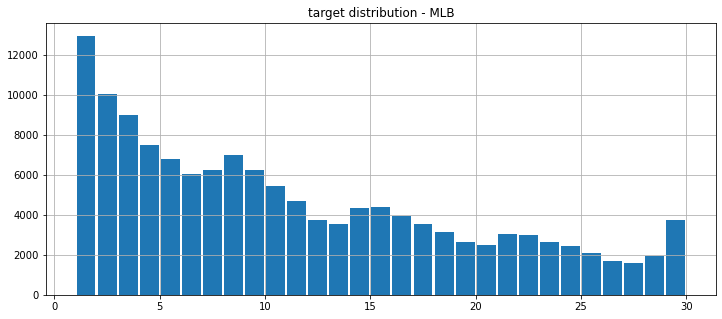

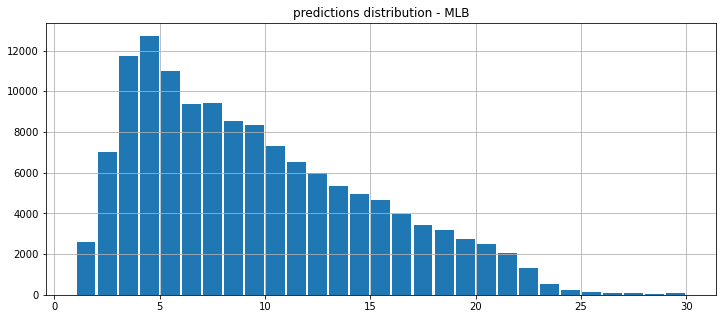

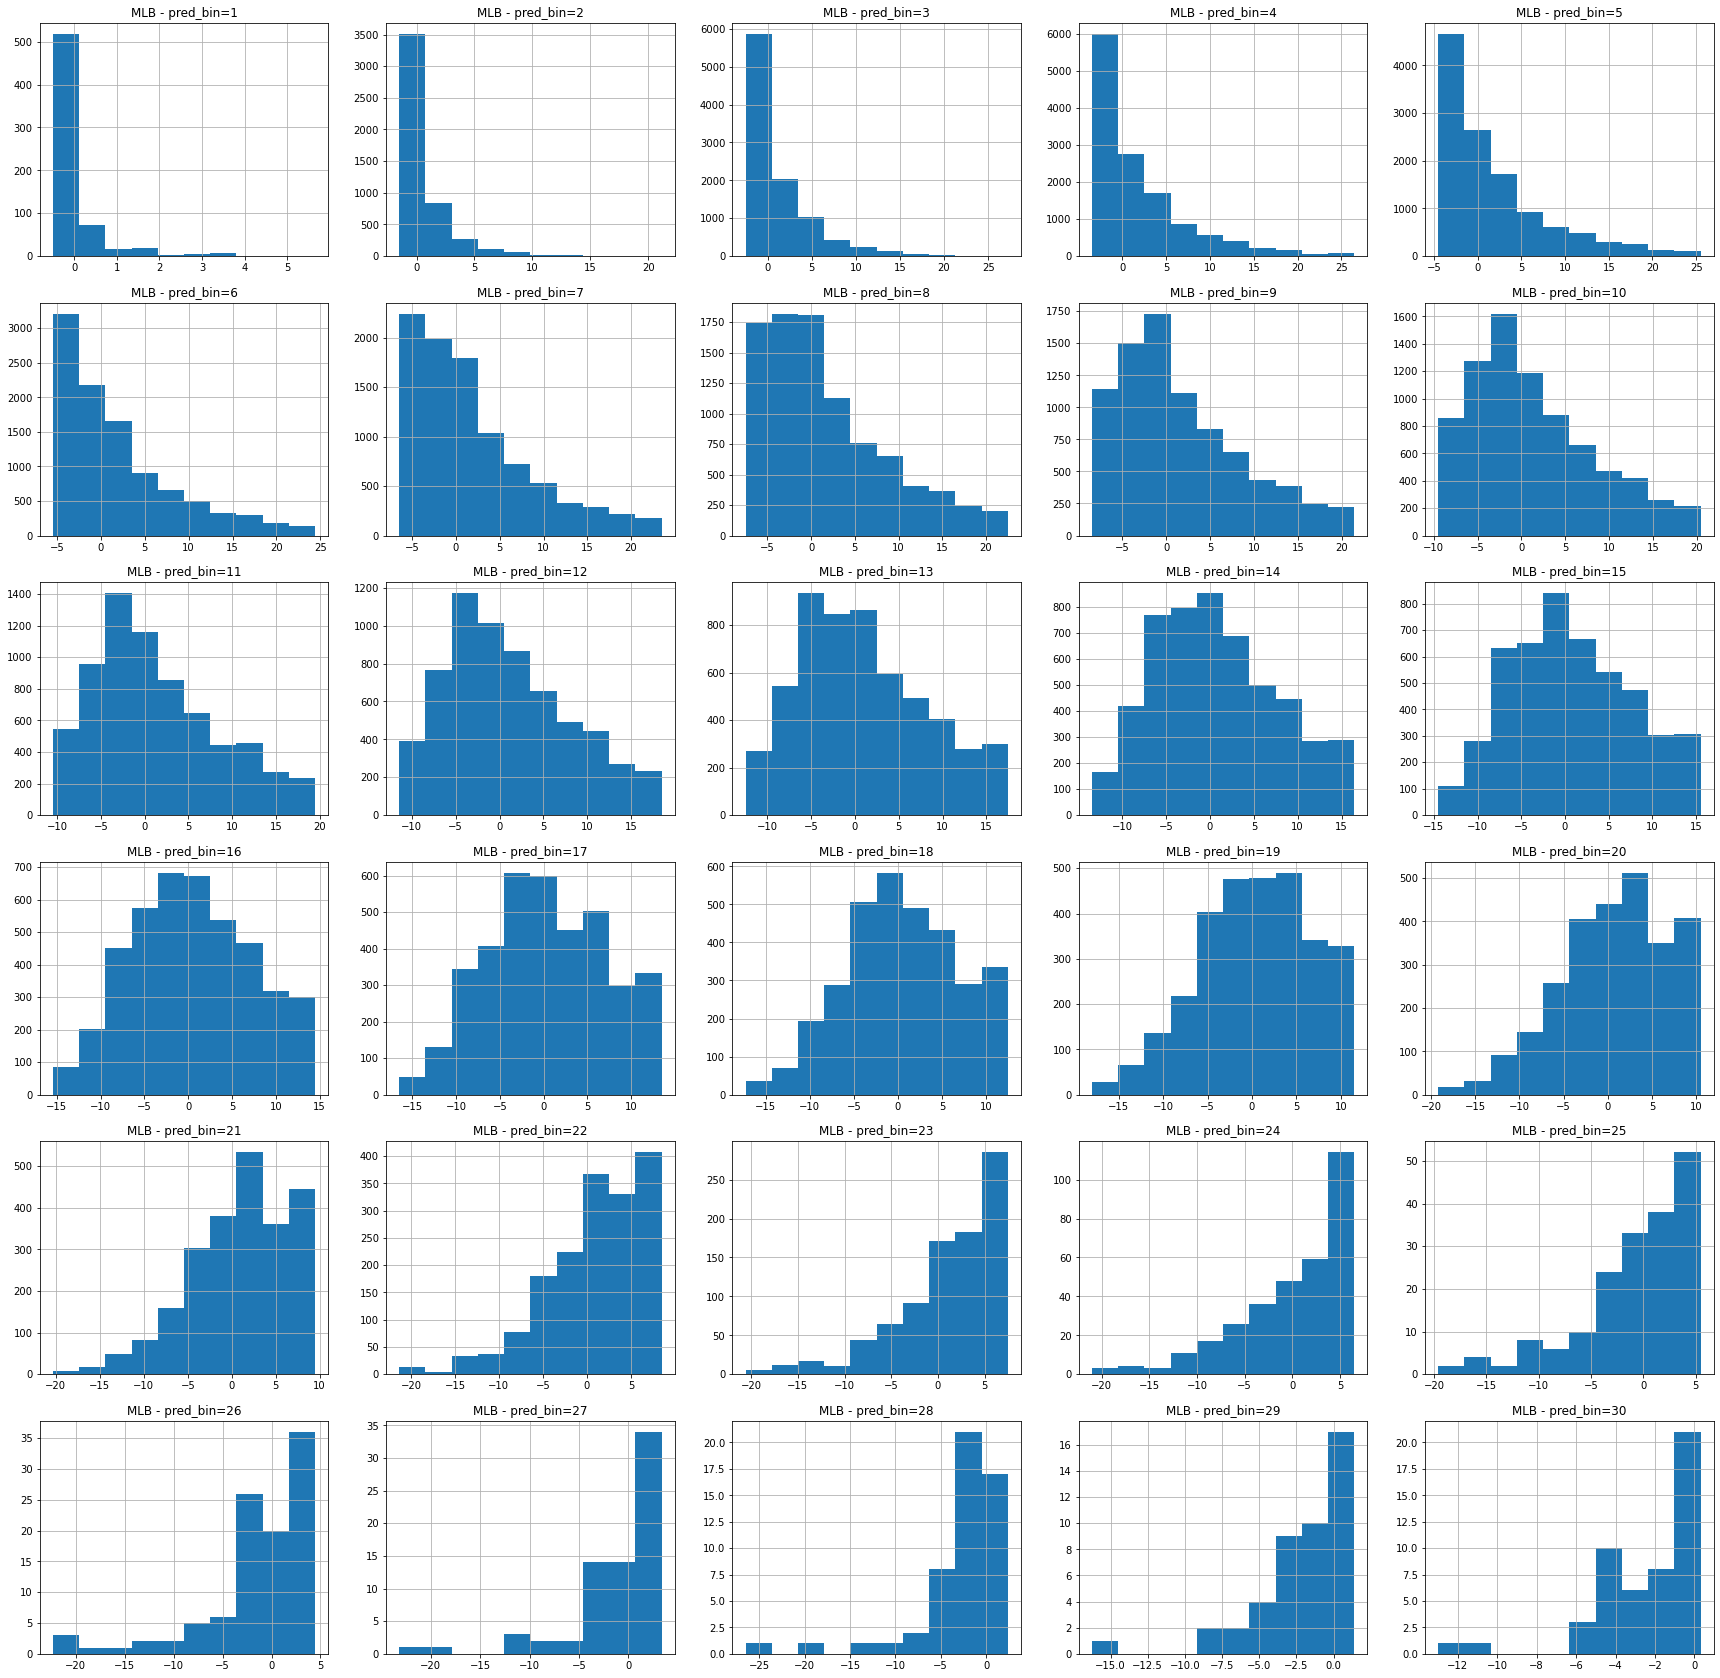

In [24]:
# results for MLB

plt.figure(figsize=(12,5))
plt.hist(oof_preds[1][target].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("target distribution - MLB")
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
plt.hist(oof_preds[1]["pred"].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("predictions distribution - MLB")
plt.grid()
plt.show()

plt.figure(figsize=(30,30))
for d in range(1,31):
    deviation = oof_preds[1].query("pred_bin == @d").eval("inventory_days - pred")
    plt.subplot(6, 5, d)
    plt.hist(deviation.values)
    plt.title(f"MLB - pred_bin={d}")
    plt.grid()
plt.show()

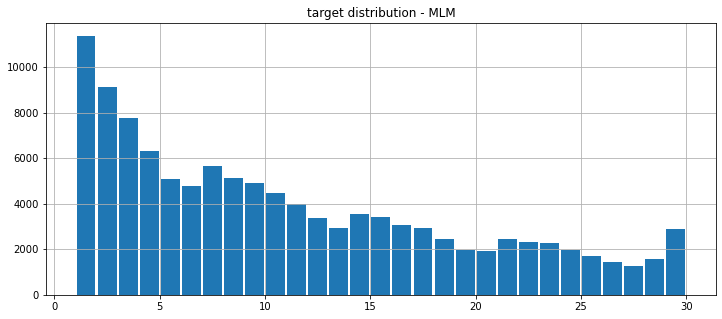

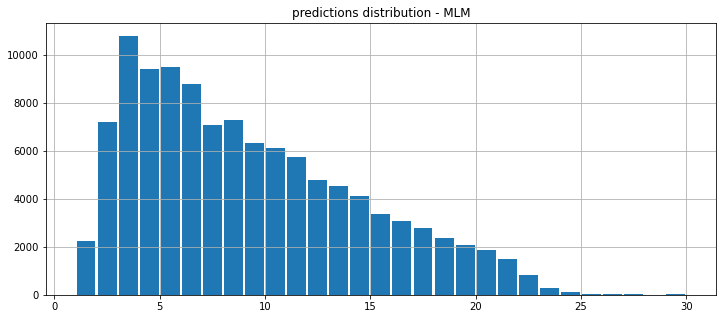

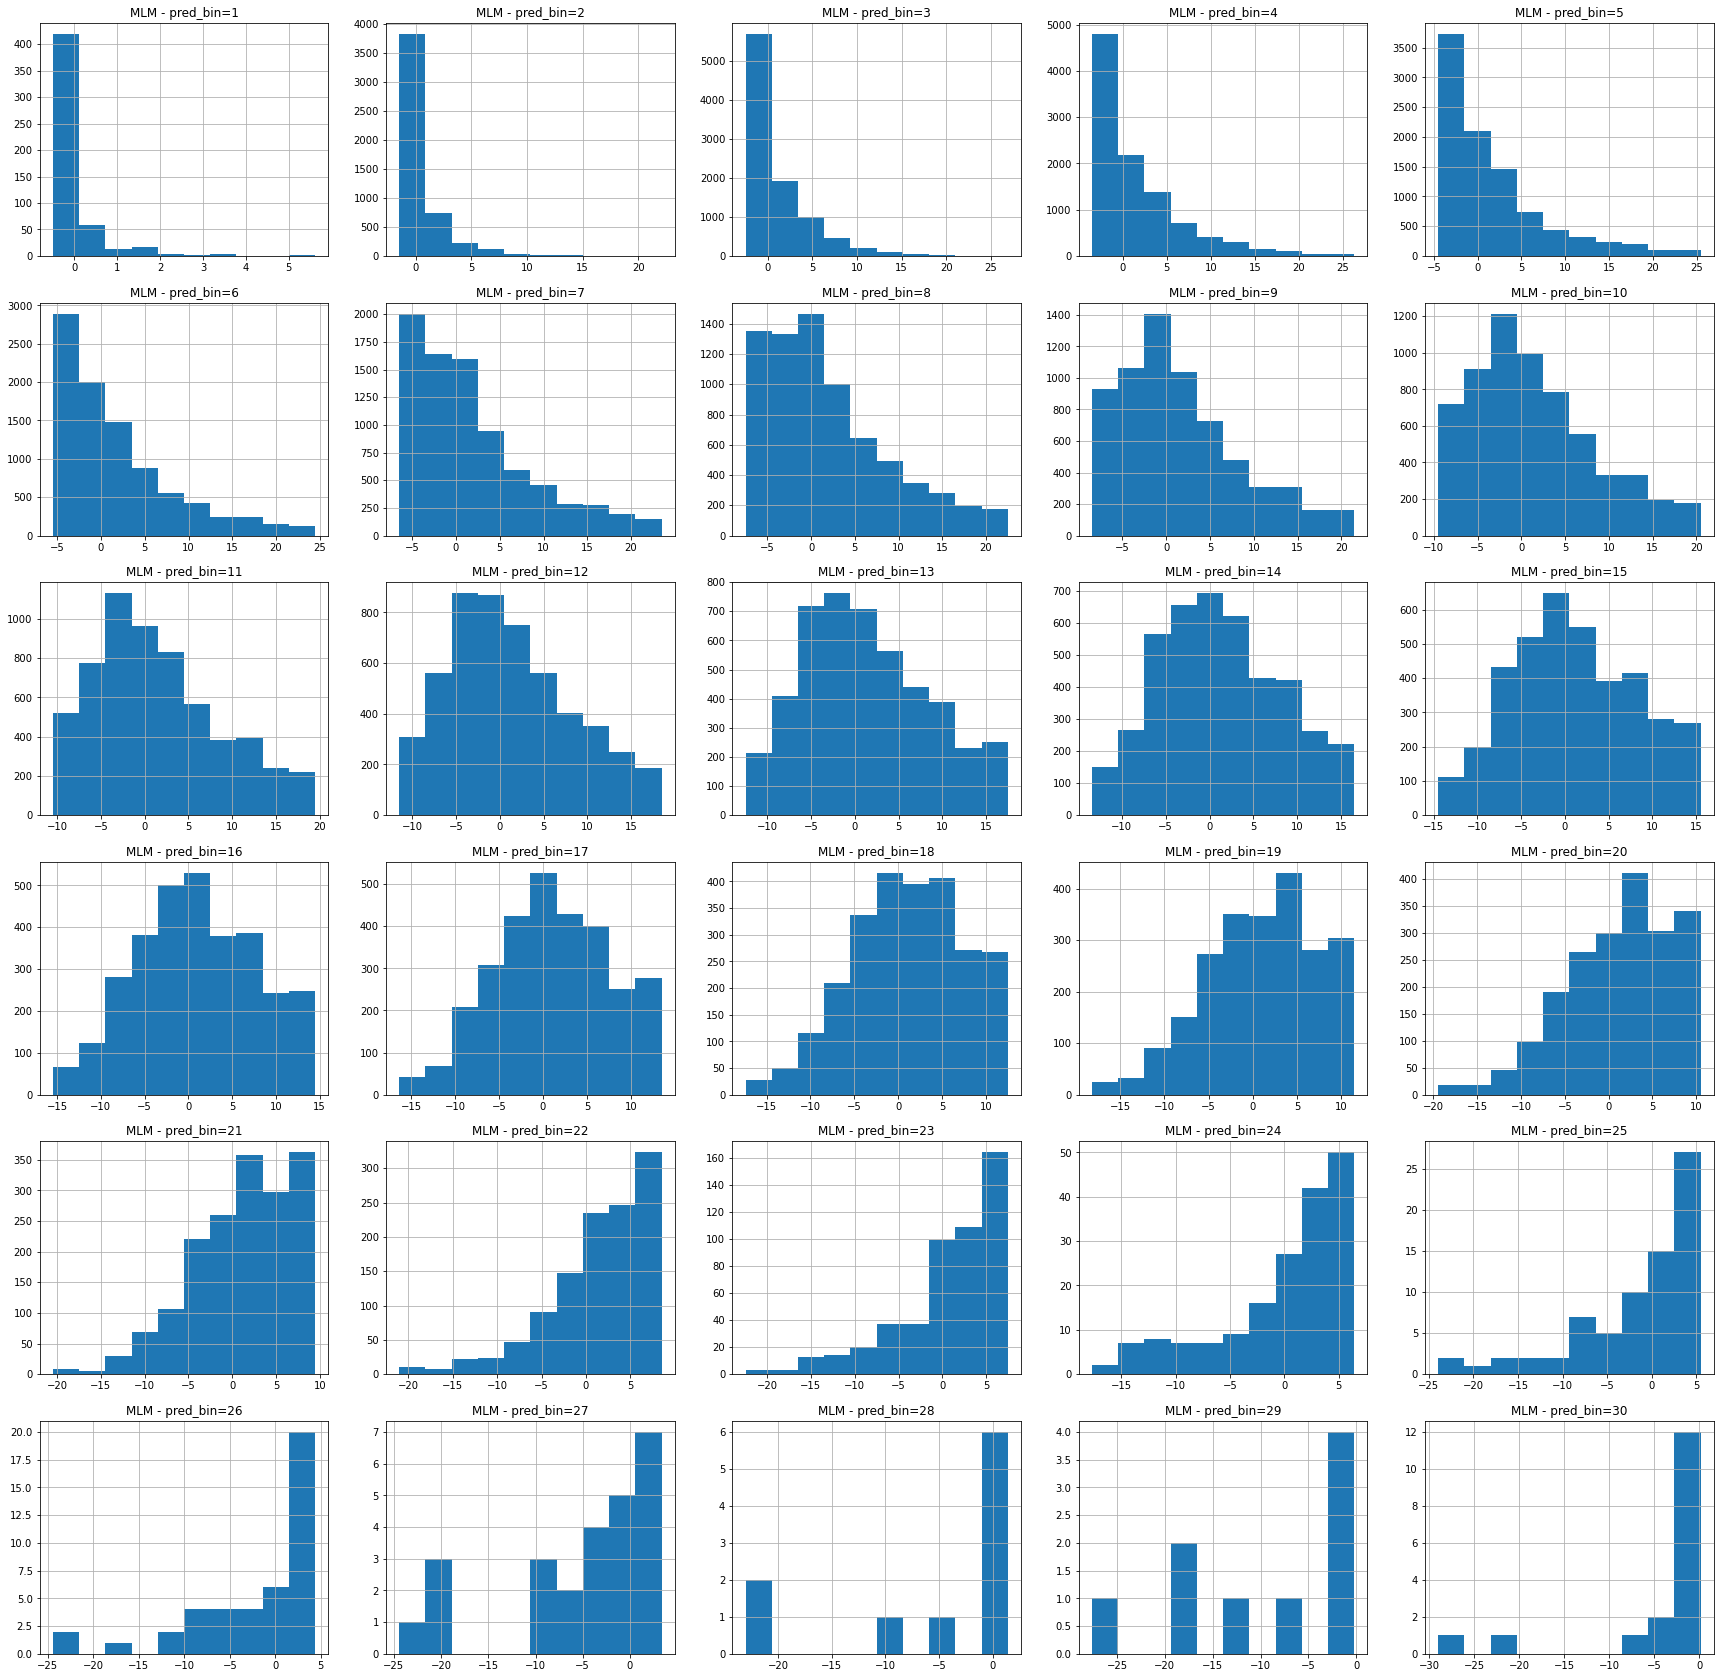

In [25]:
# results for MLM

plt.figure(figsize=(12,5))
plt.hist(oof_preds[2][target].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("target distribution - MLM")
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
plt.hist(oof_preds[2]["pred"].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("predictions distribution - MLM")
plt.grid()
plt.show()

plt.figure(figsize=(30,30))
for d in range(1,31):
    deviation = oof_preds[2].query("pred_bin == @d").eval("inventory_days - pred")
    plt.subplot(6, 5, d)
    plt.hist(deviation.values)
    plt.title(f"MLM - pred_bin={d}")
    plt.grid()
plt.show()

***
## model training

***